### import

In [2]:
%cd /content/drive/MyDrive/객체인식/postprocessing/

/content/drive/.shortcut-targets-by-id/1EuKZvbY6kj5rgLSpCOGDWSyAU4mbYw9D/객체인식/postprocessing


In [3]:
!pip install ultralytics==8.0.28

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.6/272.6 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.2 MB/s eta 0:00:00


In [4]:
from ultralytics import YOLO
import numpy as np 
import pandas as pd
from PIL import Image 
import cv2
from PIL import Image, ImageDraw, ImageFont
import json 
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os
import random
from tqdm.notebook import tqdm 
tqdm.pandas()

### model

In [5]:
def scale_segmentation(segmentation, image_size):
    h, w = image_size
    scaled_segmentation = np.zeros_like(segmentation)
    scaled_segmentation[:, 0] = segmentation[:, 0] * h
    scaled_segmentation[:, 1] = segmentation[:, 1] * w
    return [(i, j) for i, j in scaled_segmentation.astype(np.int32)]

class predict_repair_cost: 
    def __init__(self, damage_model, part_model, threshold=0.05,  cost_csv=None): 
        self.d_model = damage_model 
        self.p_model = part_model 
        self.cost_csv = cost_csv 
        self.I2L_d = damage_model.names
        self.I2L_p = part_model.names 
        self.threshold = threshold

    def get_damage(self, image_path): 
        pred = self.d_model.predict(image_path, verbose=False)[0]
        damage_parts = [self.I2L_d[int(i)] for i in pred.boxes.data[:, 5]]
        assert damage_parts , '파손 부위가 인식 되지 않습니다. 다시 사진을 찍어 주세요.'
        damage_masks = [m for m in pred.masks.data]
        return [(p, m) for p,m in zip(damage_parts, damage_masks)]

    def get_part(self, image_path): 
        pred = self.p_model.predict(image_path, verbose=False)[0]
        part_parts = [self.I2L_p[int(i)] for i in pred.boxes.data[:, 5]]
        part_masks = [m for m in pred.masks.data]
        return [(p, m) for p,m in zip(part_parts, part_masks)]

    def damaged_part(self, image_path): 
        damages = self.get_damage(image_path)
        parts = self.get_part(image_path) 
        damaged_part = {}
        for d_n, d_m in damages: 
            damage_area = d_m.sum()
            for p_n, p_m in parts: 
                # print(f'damage mask size : {d_m.size()}')         # inference 할 때에 YOLO모델 학습한 것에 맞춰서 
                # print(f'part mask size : {p_m.size()}')           # 알아서 입력 이미지 리사이즈하나?
                inter_part_damage = (d_m+p_m)
                inter_area =len(inter_part_damage[inter_part_damage==2])
                IoA = inter_area/damage_area
                if inter_part_damage.max() == 2 and IoA > self.threshold :
                    if p_n not in damaged_part: 
                        damaged_part[p_n] = [d_n]
                    else: 
                        damaged_part[p_n].append(d_n)
        return damaged_part

    def repair_price(self, image_path):
        damage_dict = self.damaged_part(image_path)
        charge_dict = {'부위' : [],'손상종류' : [], '수리방법' : [],  '수리비용' : []}
        e2k = {'change' : '교체', 'cover': '도색', 'Bonnet' : '본넷', 'Frontbumper' : '앞범퍼',
       'Rearbumper' : '뒷범퍼', 'Frontdoor' : '앞문', 'Reardoor' : '뒷문', 'Frontfender' : '앞휀더',
       'Rearfender' : '뒷휀더', 'Headlights' : '전조등', 'Rearlamp' : '후미등', 'Rockerpanel' : '옆발판', 
       'Sidemirror' : '사이드미러', 'Trunklid' : '트렁크', 'Wheel' : '바퀴', 'Windshield' : '유리창',
       'Scratched' : '긁힘', 'Breakage' : '파손', 'Separated' : '이격' , 'Crushed' : '찌그러짐'}
        damage_change = ['Breakage', 'Crushed', 'Separated']
        for k, v in damage_dict.items():            
            for damage in v: 
                if damage in damage_change:
                    temp_repair = 'change'
                    break
                else: 
                    temp_repair = 'cover'
            charge_dict['부위'].append(e2k[k])
            charge_dict['손상종류'].append(e2k[damage])
            charge_dict['수리방법'].append(e2k[temp_repair])
            charge_dict['수리비용'].append(str(self.cost_csv[self.cost_csv.part==k][temp_repair].values[0])+'원')
        return pd.DataFrame(charge_dict)

    def image_with_seg(self, image_path):
        pred_d = self.d_model.predict(image_path, verbose=False)
        pred_p = self.p_model.predict(image_path, verbose=False)

        if len(pred_d[0])==0:
            asdf = Image.open(image_path)
            print('''파손 부위가 인식 되지 않습니다. 다시 사진을 찍어 주세요.''')
            return asdf
        # assert pred_d[0] , '파손 부위가 인식 되지 않습니다. 다시 사진을 찍어 주세요.'
        segments_d = pred_d[0].masks.segments
        segments_p = pred_p[0].masks.segments
        name_d = [self.I2L_d[int(i)] for i in pred_d[0].boxes.data[:, 5]]
        name_p = [self.I2L_p[int(i)] for i in pred_p[0].boxes.data[:, 5]]
        # 이미지 생성
        img = Image.open(image_path)
        # 그리기 객체 생성
        draw = ImageDraw.Draw(img)
        # 점들의 좌표
        for idx, seg in enumerate(segments_d):
            points = scale_segmentation(seg, img.size)
            draw.line(points, fill='red', width=5)
            font = ImageFont.truetype('./고령딸기체.ttf', size=36)
            tx = seg[0][0]*img.size[0]
            ty = seg[0][1]*img.size[1]
            draw.text((tx, ty),f'{name_d[idx]}',font=font, fill='red' )
        for idx, seg in enumerate(segments_p):
            points = scale_segmentation(seg, img.size)
            draw.line(points, fill='blue', width=5)
            font = ImageFont.truetype('./고령딸기체.ttf', size=36)
            tx = int(seg[0][0]*img.size[0])
            ty = int(seg[0][1]*img.size[1])
            draw.text((tx, ty),f'{name_p[idx]}',font=font, fill='blue' )
        return img

In [6]:
model_part = YOLO('./part_new_data_epoch15.pt')
# model_damage_old = YOLO('./damage_045_640.pt')
model_damage_new = YOLO('./damageover005epech120.pt')
# model_damage_final = YOLO('./damage_001_best_100epoch.pt')
price_csv = pd.read_csv('./car_part_price.csv')

# asdf = predict_repair_cost(model_damage_old, model_part, cost_csv=price_csv)
CarAutoPrice = predict_repair_cost(model_damage_new, model_part, cost_csv=price_csv)
# zxcv = predict_repair_cost(model_damage_final, model_part, cost_csv=price_csv)

### Inference

In [27]:
img_path = random.choice(glob.glob('./test_image/*.jpg'))
img_path

'./test_image/003.jpg'

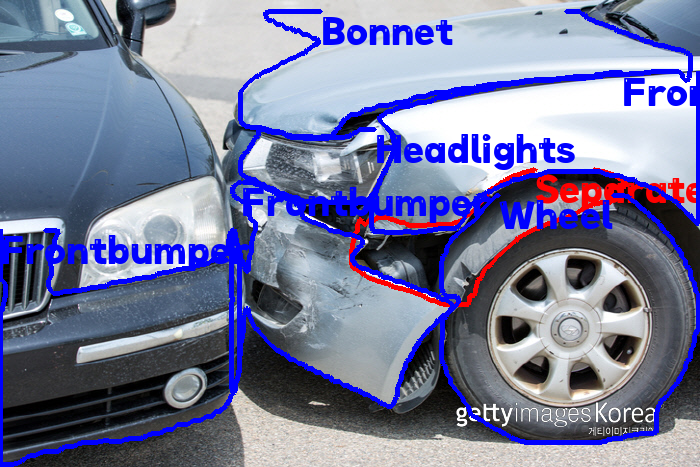

In [28]:
CarAutoPrice.image_with_seg(img_path)

In [29]:
CarAutoPrice.repair_price(img_path)

,부위,손상종류,수리방법,수리비용
0,앞휀더,이격,교체,167750원
1,앞범퍼,이격,교체,181500원
2,바퀴,이격,교체,387200원
